# Development of machine learning models to process Electronic Health Records – Explainable Models

### Preprocessing Notebook
Lok Hang Toby Lee (2431180L)

# Preprocessing
----------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn import metrics


# SET YOUR PATH FOR RESOURCES FILE HERE
resources_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP\MIMIC-III-ML/data/resources"
data_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP\MIMIC-III-ML/data/raw"

In [3]:
data = pd.read_csv(data_path+'/mimic_timeseries_data_not_imputed.csv')

In [4]:
data

,Unnamed: 0,icustay_id,subject_id,hadm_id,hours_in,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,...,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0,200003,27513,163557,0,49.000000,NaN,4.0,6.0,15.0,...,110.0,119.0,NaN,58.000000,97.0,35.000000,91.000000,NaN,77.5,NaN
1,1,200003,27513,163557,1,52.000000,NaN,NaN,NaN,NaN,...,NaN,118.0,NaN,59.000000,96.0,32.000000,88.333333,38.999999,77.5,NaN
2,2,200003,27513,163557,2,52.333333,NaN,NaN,NaN,NaN,...,NaN,116.0,NaN,59.666667,95.0,30.333333,85.333333,38.277790,77.5,NaN
3,3,200003,27513,163557,3,60.500000,NaN,NaN,NaN,NaN,...,NaN,112.0,NaN,65.500000,93.5,32.500000,86.500000,37.777790,77.5,NaN
4,4,200003,27513,163557,4,61.000000,NaN,NaN,NaN,NaN,...,NaN,108.0,NaN,67.000000,91.5,37.000000,89.500000,36.833318,77.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163074,2163074,299999,7630,129161,27,50.000000,NaN,NaN,NaN,NaN,...,130.0,72.0,NaN,68.333298,97.0,25.000000,105.000000,NaN,88.5,NaN
2163075,2163075,299999,7630,129161,28,48.000000,NaN,NaN,NaN,NaN,...,NaN,70.0,NaN,66.666702,95.0,22.000000,104.000000,NaN,88.5,NaN
2163076,2163076,299999,7630,129161,29,49.000000,NaN,4.0,6.0,15.0,...,NaN,70.0,NaN,67.666702,94.0,24.000000,105.000000,NaN,88.5,NaN
2163077,2163077,299999,7630,129161,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
import seaborn as sns
"""
Plots histograms of all columns in train data
"""
x_features=['subject_id', 'hadm_id', 'hours_in', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH']
       
for i in x_features:
    sns.set_theme()
    # Uncomment to see histograms of all columns
    #sns.displot(data[i], bins=82, kde=True)

### Extract the variables and count the missing data

In [6]:
# Read in the data and only select the continuous variables:
config = json.load(open(resources_path + '/discretizer_config.json', 'r'))
is_categorical = config['is_categorical_channel']
categorical_var = [key for key, value in config['is_categorical_channel'].items() if value][1:]
patient_identifiers = ['icustay_id', 'subject_id', 'hadm_id', 'hours_in']
data = pd.read_csv(data_path+'/mimic_timeseries_data_not_imputed.csv')

# Filter out subjects with length of stay < 48 hours for the in-hospital mortality task:
y = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'Y')['los']
indices_to_remove = []
for i, row in y.iteritems():
    if row < 48:
        indices_to_remove.append(i)
        
data = data.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
y = y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
data = data[data['hours_in'] < 48].reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in']).drop('index', axis = 1)

In [7]:
print('Number of samples: ', data.shape[0])
print('Number of ICU stays: ', len(data.groupby('icustay_id')))

non_nans_per_predictor = np.array(list(data.groupby('icustay_id').apply(lambda x: np.count_nonzero(~np.isnan(x.values[:, 4:]), 
                                                                                           axis = 0))))
total_missing_predictors = 0
for subject in non_nans_per_predictor:
    for predictor in subject:
        if predictor == 0:
            total_missing_predictors += 1
print('Total number of predictors that are missing at every hour (per subject): ', total_missing_predictors)

Number of samples:  843312
Number of ICU stays:  17569
Total number of predictors that are missing at every hour (per subject):  29010


### Imputation of all predictors

In [8]:
# Initialize matrix to store the results of different imputation methods:
data = data.drop('Unnamed: 0', axis = 1)
original_data = pd.DataFrame(index = data.index, columns = data.columns)
results_mean_imp = pd.DataFrame(index = data.index, columns = data.columns)
results_joint_imp = pd.DataFrame(index = data.index, columns = data.columns)

In [9]:
counter = 0
n_folds = 100
unique_icustays = np.unique(data.index.get_level_values('icustay_id'))
kf = KFold(n_splits=n_folds, random_state=0, shuffle=True)
for train_index, test_index in kf.split(unique_icustays):
    
    print('Imputing fold ', counter + 1, '/', n_folds, end = '\r')
    counter += 1
    
    train_index = unique_icustays[train_index]
    test_index = unique_icustays[test_index]
    
    data_train = data.iloc[data.index.get_level_values('icustay_id').isin(train_index)]
    data_test = data.iloc[data.index.get_level_values('icustay_id').isin(test_index)]
    for i in range(len(data.columns)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            data_test.loc[:, data.columns[i]] = np.round(data_test.loc[:, data.columns[i]])
    original_data.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = data_test
    
    # Replace the test data with NaNs so we can learn the values:
    data_test = np.empty(data_test.shape)
    data_test[:] = np.nan
    
    # Mean imputation:
    mean_imp = np.nanmean(data_train, axis = 0)
    for i in range(len(mean_imp)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            mean_imp[i] = np.round(mean_imp[i])  
    results_mean_imp.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = mean_imp
    
    # Joint imputation: first extract the mu and covariance, then sample from the Gaussian distribution:    
    mu = np.nanmean(data_train.values, axis = 0)
    data_train_no_nans = data_train.values
    for i in range(data_train.values.shape[1]):
        data_train_no_nans[:, i] = np.nan_to_num(data_train.values[:, i], nan = mu[i])
    data_train_no_nans = data_train_no_nans.T
    sigma = np.cov(data_train_no_nans)
    sample = np.random.multivariate_normal(mu, sigma, size = len(unique_icustays))
    sample = np.mean(sample, axis = 0)
    for i in range(len(sample)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            sample[i] = np.round(sample[i])
    results_joint_imp.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = sample

In [10]:
# Evaluate the performances of the two imputation methods: When using 100 folds and 17569 samples
rmse_meanimp = np.mean(np.sqrt(np.mean((results_mean_imp - original_data)**2)))
rmse_jointimp = np.mean(np.sqrt(np.mean((results_joint_imp - original_data)**2)))
print('Root mean-squared error mean imputation:', rmse_meanimp)
print('Root mean-squared error joint imputation:', rmse_jointimp)

Root mean-squared error mean imputation: 11.492452443679584
Root mean-squared error joint imputation: 11.492573536317547


In [11]:
# Using 100 folds and 17569 samples:
rmse_per_predictor_mean = np.sqrt(np.mean((results_mean_imp - original_data)**2))
rmse_per_predictor_jointimp = np.sqrt(np.mean((results_joint_imp - original_data)**2))
print('RMSE per predictor:')
print('Mean\tJoint\tPredictor\n')
for i in range(len(rmse_per_predictor_mean)):
    print(str(round(rmse_per_predictor_mean[i], 2)) + '\t' + str(round(rmse_per_predictor_jointimp[i], 2)) +'\t' + results_mean_imp.columns[i])

RMSE per predictor:
Mean	Joint	Predictor

13.8	13.8	Diastolic blood pressure
0.19	0.19	Fraction inspired oxygen
1.12	1.12	Glascow coma scale eye opening
1.39	1.39	Glascow coma scale motor response
3.79	3.79	Glascow coma scale total
1.9	1.9	Glascow coma scale verbal response
58.52	58.52	Glucose
17.68	17.68	Heart Rate
12.76	12.76	Height
15.17	15.17	Mean blood pressure
3.49	3.49	Oxygen saturation
5.83	5.83	Respiratory rate
21.62	21.62	Systolic blood pressure
0.82	0.82	Temperature
25.72	25.72	Weight
0.08	0.08	pH


In [12]:
# Only impute the NaNs in the original data:
imputed_data = original_data.fillna(results_joint_imp)
imputed_data.to_csv(data_path+'/imputed_in_hospital_mortality_data_no_ffill.csv')

In [13]:
imputed_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                            49.0   
                              1                            52.0   
                              2                       52.333333   
                              3                            60.5   
                              4                            61.0   
...                                                         ...   
299995     28775      134959  43                           82.0   
                              44                      60.225964   
                              45                      60.225964   
                              46                           65.0   
                              47                      60.225964   

                                       Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                        0.546382   
                              1                        0.546382   
                              2                        0.546382   
                              3                        0.546382   
                              4                        0.546382   
...                                                         ...   
299995     28775      134959  43                       0.546271   
                              44                       0.546271   
                              45                       0.546271   
                              46                       0.546271   
                              47                       0.546271   

                                       Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                  
200003     27513      163557  0                                   4.0   
                              1                                   3.0   
                              2                                   3.0   
                              3                                   3.0   
                              4                                   3.0   
...                                                               ...   
299995     28775      134959  43                                  3.0   
                              44                                  3.0   
                              45                                  3.0   
                              46                                  4.0   
                              47                                  3.0   

                                       Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                     
200003     27513      163557  0                                      6.0   
                              1                                      5.0   
                              2                                      5.0   
                              3                                      5.0   
                              4                                      5.0   
...                                                                  ...   
299995     28775      134959  43                                     5.0   
                              44                                     5.0   
                              45                                     5.0   
                              46                                     6.0   
                              47                                     5.0   

                                       Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                            15.0   
                              1                            12.0   
                              2                            12.0   
                     

### In-hospital mortality prediction using joint modelling imputation vs. mean imputation

In [15]:
# Load newly imputed data, preprocessed data, and outcomes:
imputed_data = pd.read_csv(data_path+'imputed_in_hospital_mortality_data_no_ffill.csv')
X = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'X')
Y = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'Y')
X = X.sort_index(axis = 0, level = 'icustay_id')
Y = Y.sort_index(axis = 0, level = 'icustay_id')

# Load the config file that contains information about continuous/categorical variables:
config = json.load(open(resources_path+'/discretizer_config.json', 'r'))
categorical_var = [key for key, value in  config['is_categorical_channel'].items() if value][1:]
continuous_var = [key for key, value in  config['is_categorical_channel'].items() if not value]

In [16]:
# Remove ICU stays that took less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
X = X.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
Y = Y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
X = X[X['hours_in'] < 48].reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in'])
imputed_data = imputed_data.set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in'])

In [24]:
imputed_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.159609   
                              1                         0.169381   
                              2                         0.170467   
                              3                         0.197068   
                              4                         0.198697   
...                                                          ...   
299995     28775      134959  43                        0.267101   
                              44                        0.196176   
                              45                        0.196176   
                              46                        0.211726   
                              47                        0.196176   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.425801   
                              1                         0.425801   
                              2                         0.425801   
                              3                         0.425801   
                              4                         0.425801   
...                                                          ...   
299995     28775      134959  43                        0.425659   
                              44                        0.425659   
                              45                        0.425659   
                              46                        0.425659   
                              47                        0.425659   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                    4.0   
                              1                                    3.0   
                              2                                    3.0   
                              3                                    3.0   
                              4                                    3.0   
...                                                                ...   
299995     28775      134959  43                                   3.0   
                              44                                   3.0   
                              45                                   3.0   
                              46                                   4.0   
                              47                                   3.0   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                       6.0   
                              1                                       5.0   
                              2                                       5.0   
                              3                                       5.0   
                              4                                       5.0   
...                                                                   ...   
299995     28775      134959  43                                      5.0   
                              44                                      5.0   
                              45                                      5.0   
                              46                                      6.0   
                              47                                      5.0   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                             15.0   
                              1                             12.0   
                              2  

In [18]:
# Minmax standardization of the continuous variables:
def minmax(x):
    mins = x.min()
    maxes = x.max()
    x_std = (x - mins) / (maxes - mins)
    return x_std

for column in imputed_data.columns:
    if column not in categorical_var:
        imputed_data.loc[:, column] = minmax(imputed_data.loc[:, column].values)

In [26]:
imputed_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.159609   
                              1                         0.169381   
                              2                         0.170467   
                              3                         0.197068   
                              4                         0.198697   
...                                                          ...   
299995     28775      134959  43                        0.267101   
                              44                        0.196176   
                              45                        0.196176   
                              46                        0.211726   
                              47                        0.196176   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.425801   
                              1                         0.425801   
                              2                         0.425801   
                              3                         0.425801   
                              4                         0.425801   
...                                                          ...   
299995     28775      134959  43                        0.425659   
                              44                        0.425659   
                              45                        0.425659   
                              46                        0.425659   
                              47                        0.425659   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                    4.0   
                              1                                    3.0   
                              2                                    3.0   
                              3                                    3.0   
                              4                                    3.0   
...                                                                ...   
299995     28775      134959  43                                   3.0   
                              44                                   3.0   
                              45                                   3.0   
                              46                                   4.0   
                              47                                   3.0   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                       6.0   
                              1                                       5.0   
                              2                                       5.0   
                              3                                       5.0   
                              4                                       5.0   
...                                                                   ...   
299995     28775      134959  43                                      5.0   
                              44                                      5.0   
                              45                                      5.0   
                              46                                      6.0   
                              47                                      5.0   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                             15.0   
                              1                             12.0   
                              2  

In [20]:
x = np.array(list(imputed_data.reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

"""
Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
"""

# Function that plots roc
def plot_roc(classifier,model,X,y,n_splits,):
    cv = KFold(n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic (ROC): "+model,
    )
    ax.legend(loc="lower right")
    plt.show()

In [28]:
from sklearn.metrics import *

# function that plots the confusion matrix
def plot_confusion(y,y_pred,name):
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix (' + name + ')')

[Logistic Regression]
f1_macro: 0.648 (+/- 0.012)
Accuracy: 0.893 (+/- 0.003)
Precision: 0.638 (+/- 0.031)
Recall: 0.246 (+/- 0.017)


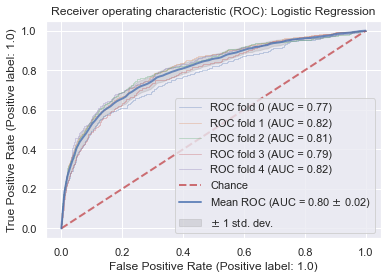

[Random Forest]
f1_macro: 0.640 (+/- 0.014)
Accuracy: 0.899 (+/- 0.002)
Precision: 0.806 (+/- 0.026)
Recall: 0.212 (+/- 0.021)


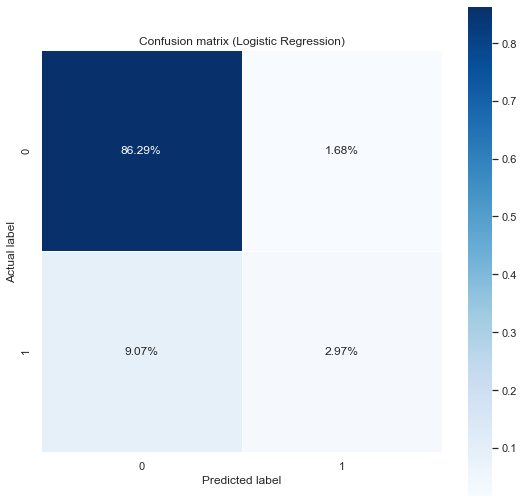

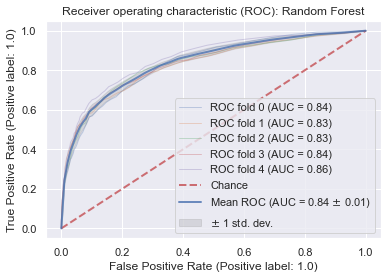

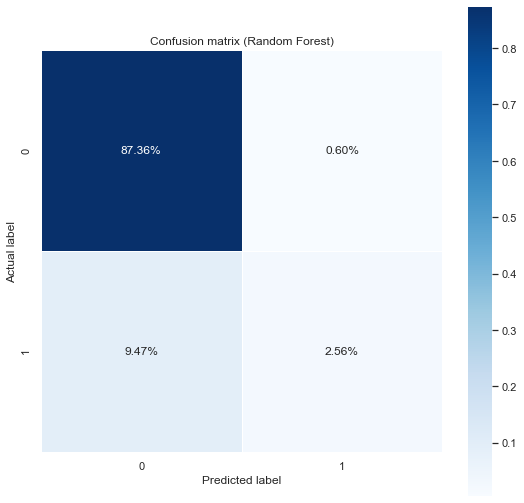

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

# defines all the models used for comparison


clf_lg = LogisticRegression()

clf_rf = RandomForestClassifier()


results=[]
for clf, label in zip([clf_lg, clf_rf], ['Logistic Regression', 'Random Forest']):

     # cross_val_score returns the cross validation score given X,y data, the scoring method and the number of folds
     f1_macro = cross_val_score(clf, x, y, scoring='f1_macro', cv=5)
     accuracy = cross_val_score(clf, x, y, scoring='accuracy', cv=5)
     precision = cross_val_score(clf, x, y, scoring='precision', cv=5)
     recall = cross_val_score(clf, x, y, scoring='recall', cv=5)

     # cross_val_predict returns the prediction, which is used to create useful plots for comparing performance
     y_pred= cross_val_predict(clf, x, y, cv=5)
     
     print("[%s]"%(label))
     print("f1_macro: %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
     print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
     print("Precision: %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
     print("Recall: %0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))

     # Plots the ROC and confusion matrix, this is commented for readibility of code.
     plot_roc(clf,label,x,y,n_splits=5)
     plot_confusion(y,y_pred,label)

### Undersample function

In [30]:
def undersample_majority(x_train, y_train):
    
    # Separate the positive and negative x/y data:
    pos_features = x_train[y_train == 1]
    neg_features = x_train[y_train == 0]
    pos_labels = y_train[y_train == 1]
    neg_labels = y_train[y_train == 0]
    
    # Count the number of negative data points, and select that many from the positive data points. This means that 
    # positive samples will be 'copied' or repeated and hence occur multiple times in the training data:
    ids = np.arange(len(neg_features))
    choices = np.random.choice(ids, len(pos_features))
    res_neg_features = neg_features[choices]
    res_neg_labels = neg_labels[choices]
    
    # Combine the resamples and negative data points, and shuffle:
    resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
    resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    return resampled_features, resampled_labels

[Logistic Regression]
f1_macro: 0.716 (+/- 0.010)
Accuracy: 0.717 (+/- 0.011)
Precision: 0.741 (+/- 0.022)
Recall: 0.668 (+/- 0.019)


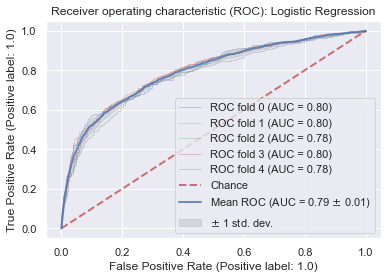

[Random Forest]
f1_macro: 0.776 (+/- 0.009)
Accuracy: 0.775 (+/- 0.011)
Precision: 0.774 (+/- 0.015)
Recall: 0.774 (+/- 0.016)


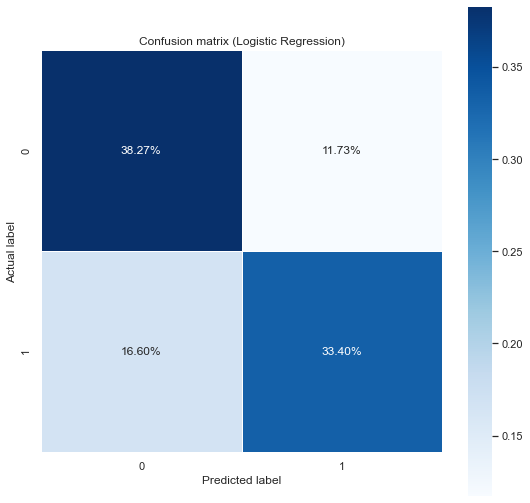

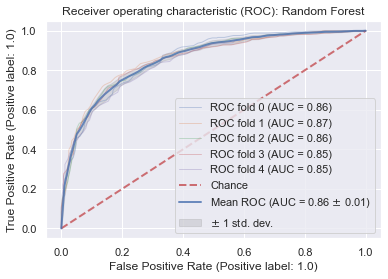

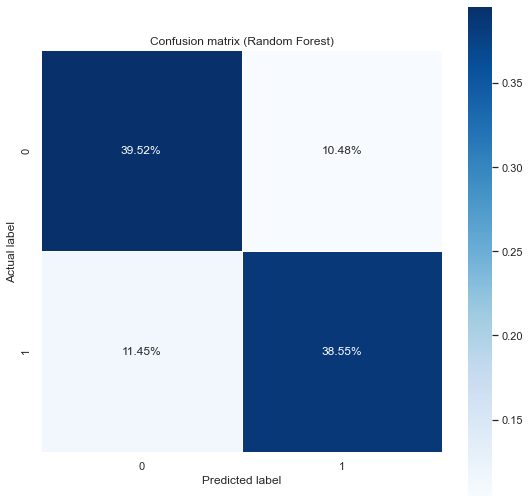

In [31]:
clf_lg = LogisticRegression()

clf_rf = RandomForestClassifier()


results=[]

u_x,u_y = undersample_majority(x,y)
for clf, label in zip([clf_lg, clf_rf], ['Logistic Regression', 'Random Forest']):

     # cross_val_score returns the cross validation score given X,y data, the scoring method and the number of folds
     f1_macro = cross_val_score(clf, u_x, u_y, scoring='f1_macro', cv=5)
     accuracy = cross_val_score(clf, u_x, u_y, scoring='accuracy', cv=5)
     precision = cross_val_score(clf, u_x, u_y, scoring='precision', cv=5)
     recall = cross_val_score(clf, u_x, u_y, scoring='recall', cv=5)
     
     # cross_val_predict returns the prediction, which is used to create useful plots for comparing performance
     y_pred= cross_val_predict(clf, u_x, u_y, cv=5)
     
     print("[%s]"%(label))
     print("f1_macro: %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
     print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
     print("Precision: %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
     print("Recall: %0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))

     # Plots the ROC and confusion matrix, this is commented for readibility of code.
     plot_roc(clf,label,u_x,u_y,n_splits=5)
     plot_confusion(u_y,y_pred,label)

# Standard imputated method

In [47]:
X

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.159609   
                              1                         0.169381   
                              2                         0.170467   
                              3                         0.197068   
                              4                         0.198697   
...                                                          ...   
299995     28775      134959  43                        0.267101   
                              44                        0.267101   
                              45                        0.267101   
                              46                        0.211726   
                              47                        0.211726   

                                        Fraction inspired oxygen   Glucose  \
icustay_id subject_id hadm_id hours_in                                       
200003     27513      163557  0                         0.407795  0.049422   
                              1                         0.407795  0.049422   
                              2                         0.407795  0.049422   
                              3                         0.407795  0.049422   
                              4                         0.407795  0.049422   
...                                                          ...       ...   
299995     28775      134959  43                        0.407795  0.033376   
                              44                        0.407795  0.033376   
                              45                        0.407795  0.033376   
                              46                        0.407795  0.033376   
                              47                        0.407795  0.033376   

                                        Heart Rate   Height  \
icustay_id subject_id hadm_id hours_in                        
200003     27513      163557  0           0.396667  0.70402   
                              1           0.393333  0.70402   
                              2           0.386667  0.70402   
                              3           0.373333  0.70402   
                              4           0.360000  0.70402   
...                                            ...      ...   
299995     28775      134959  43          0.246667  0.70402   
                              44          0.240000  0.70402   
                              45          0.273333  0.70402   
                              46          0.243333  0.70402   
                              47          0.243333  0.70402   

                                        Mean blood pressure  \
icustay_id subject_id hadm_id hours_in                        
200003     27513      163557  0                    0.139241   
                              1                    0.142405   
                              2                    0.144515   
                              3                    0.162975   
                              4                    0.167722   
...                                                     ...   
299995     28775      134959  43                   0.250000   
                              44                   0.250000   
                              45                   0.250000   
                              46                   0.212025   
                              47                   0.212025   

                                        Oxygen saturation  Respiratory rate  \
icustay_id subject_id hadm_id hours_in                                        
200003     27513      163557  0                     0.970          0.116667   
                              1                     0.960          0.106667   
                              2                     0.950          0.101111   
                              3                     0.935          0.108333   
                          

In [48]:
x_features=['Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH']
rfe_x=X[x_features]

In [51]:
x = np.array(list(X.reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

[Logistic Regression]
f1_macro: 0.751 (+/- 0.012)
Accuracy: 0.751 (+/- 0.012)
Precision: 0.758 (+/- 0.016)
Recall: 0.738 (+/- 0.016)


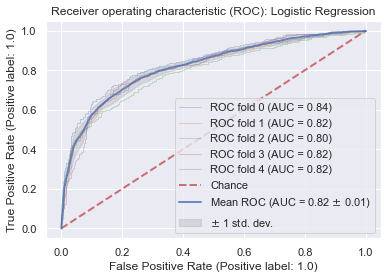

[Random Forest]
f1_macro: 0.793 (+/- 0.016)
Accuracy: 0.799 (+/- 0.013)
Precision: 0.820 (+/- 0.023)
Recall: 0.763 (+/- 0.020)


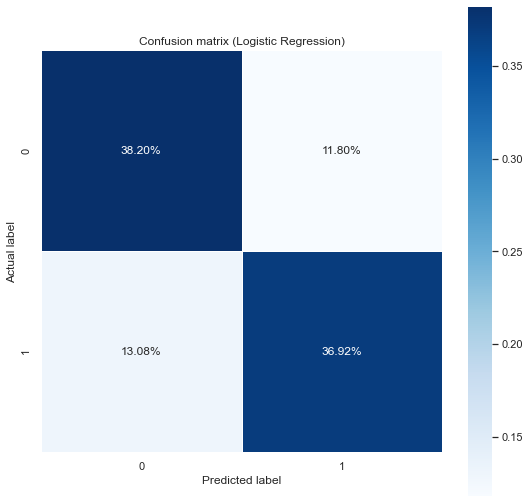

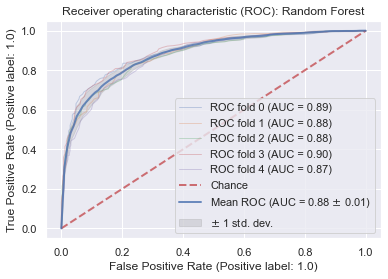

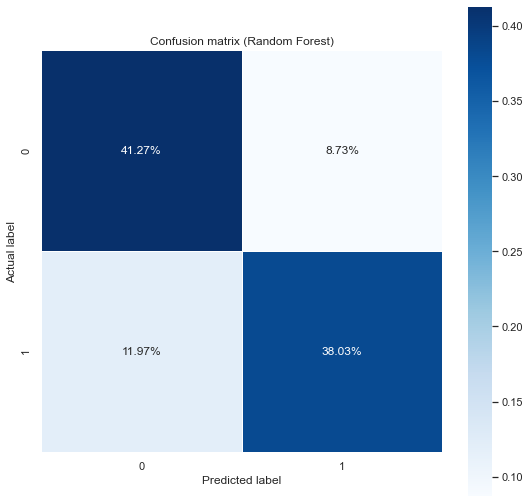

In [52]:
clf_lg = LogisticRegression()

clf_rf = RandomForestClassifier()

results=[]

u_x,u_y = undersample_majority(x,y)
for clf, label in zip([clf_lg, clf_rf], ['Logistic Regression', 'Random Forest']):

     # cross_val_score returns the cross validation score given X,y data, the scoring method and the number of folds
     f1_macro = cross_val_score(clf, u_x, u_y, scoring='f1_macro', cv=5)
     accuracy = cross_val_score(clf, u_x, u_y, scoring='accuracy', cv=5)
     precision = cross_val_score(clf, u_x, u_y, scoring='precision', cv=5)
     recall = cross_val_score(clf, u_x, u_y, scoring='recall', cv=5)
     
     # cross_val_predict returns the prediction, which is used to create useful plots for comparing performance
     y_pred= cross_val_predict(clf, u_x, u_y, cv=5)
     
     print("[%s]"%(label))
     print("f1_macro: %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
     print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
     print("Precision: %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
     print("Recall: %0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))

     # Plots the ROC and confusion matrix, this is commented for readibility of code.
     plot_roc(clf,label,u_x,u_y,n_splits=5)
     plot_confusion(u_y,y_pred,label)